In [31]:
import tqdm
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import time

from matplotlib import style
style.use('seaborn-white')

from numpy import genfromtxt
#gpytorch.settings.max_cg_iterations(2000)

from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/mnt/bgfs/belal/4214113/ipykernel_60511/4105414838.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


In [32]:
my_data = genfromtxt('../../../Data/deterministicCase/deterministicData.csv', delimiter=',')
theta_sim = my_data[:,0]
theta_d_sim = my_data[:,1]
x_sim = my_data[:,2]
x_d_sim = my_data[:,3]
forceIn = my_data[:,4]
theta_dd_sim = my_data[:,5]
x_dd_sim = my_data[:,6]

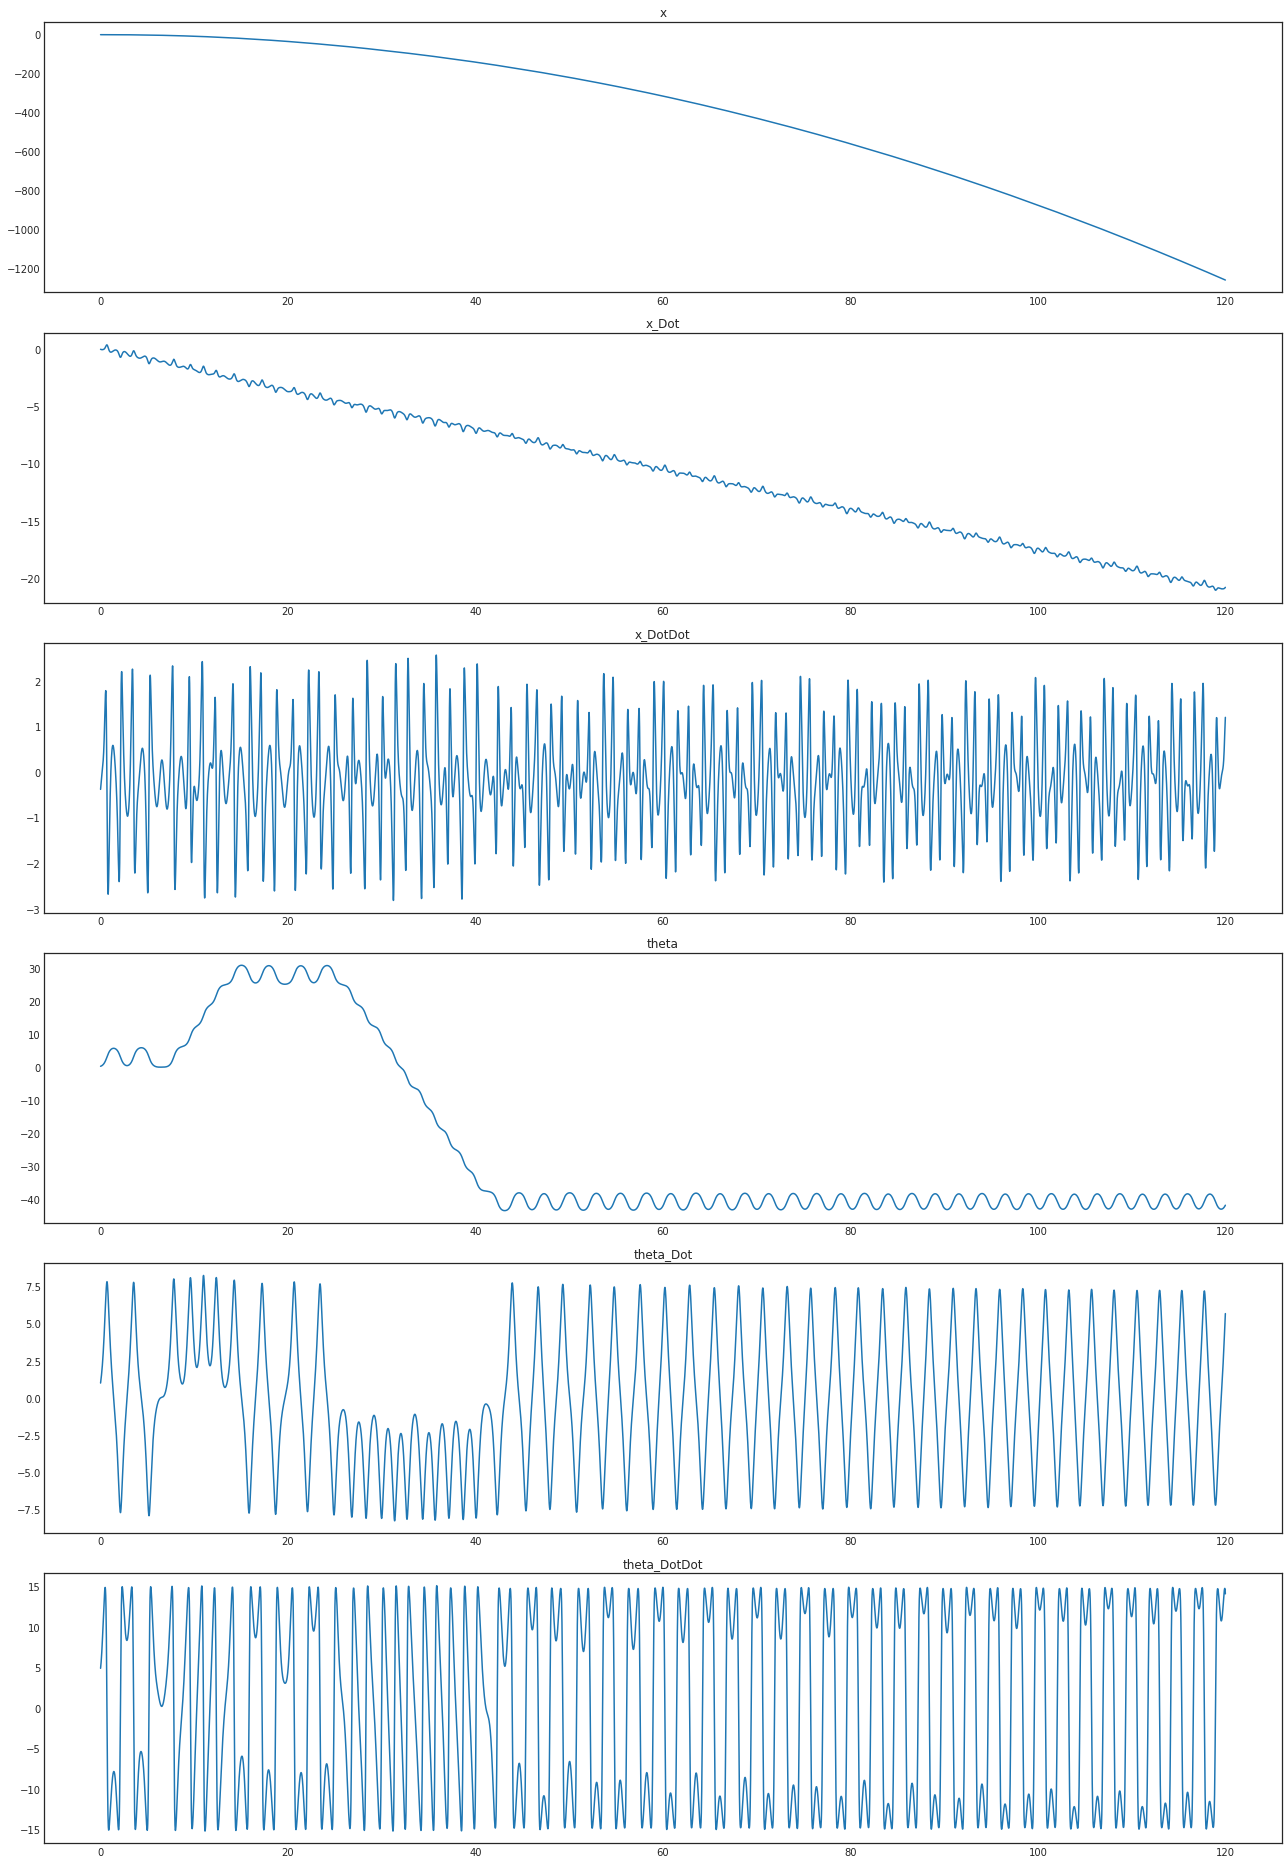

In [33]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

dt = 0.01
noOfSteps = 12000
timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False) # for plotting 

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

In [34]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

Y_theta = ((theta_dd_sim-theta_dd_sim_mean)/theta_dd_sim_stdev)
Y_x = ((x_dd_sim-x_dd_sim_mean)/x_dd_sim_stdev)
X_prior = np.stack(((theta_sim-theta_sim_mean)/theta_sim_stdev,(theta_d_sim-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [35]:
# Numpy to tensors 
X_train = torch.from_numpy(X_train).float()
Y_train_theta = torch.from_numpy(Y_train_theta).float()
Y_train_x = torch.from_numpy(Y_train_x).float()
X_prior = torch.from_numpy(X_prior).float()
Y_theta = torch.from_numpy(Y_theta).float()
Y_x = torch.from_numpy(Y_x).float()

# Putting tensors on GPU
if torch.cuda.is_available():
    X_train, Y_train_theta, Y_train_x, X_prior, Y_theta, Y_x = X_train.cuda(), Y_train_theta.cuda(), Y_train_x.cuda(), X_prior.cuda(), Y_theta.cuda(), Y_x.cuda()

In [36]:
train_dataset = TensorDataset(X_train, Y_train_theta)
train_loader = DataLoader(train_dataset, batch_size=4024, shuffle=True)

test_dataset = TensorDataset(X_prior, Y_theta)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [37]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

indPts = np.sort(np.random.randint(low=0, high=8000, size=(3000,)))
inducing_points = X_train[indPts,:]
#inducing_points = X_train[:2000, :]
#inducing_points = torch.randn(4000, X_train.size(-1), dtype=X_train.dtype, device=X_train.device)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [38]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Y_train_theta.size(0))

start_time = time.time()
losses = []
num_epochs = 7000
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False, disable=True)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
    if i%100==0:
        print('Loss: %.3f' % (loss.item()))
print('Total time is %s:' %(time.time() - start_time)) 

Epoch:   0%|          | 0/7000 [00:00<?, ?it/s]

Loss: 3.206
Loss: 0.879
Loss: 0.405
Loss: 0.169
Loss: 0.056
Loss: -0.049
Loss: 0.187
Loss: -0.148
Loss: -0.246
Loss: -0.255
Loss: -0.262
Loss: -0.229
Loss: -0.210
Loss: -0.136
Loss: -0.006
Loss: 0.219
Loss: -0.305
Loss: -0.368
Loss: -0.339
Loss: -0.189
Loss: 0.175
Loss: -0.351
Loss: -0.375
Loss: -0.254
Loss: 0.140
Loss: -0.228
Loss: -0.394
Loss: -0.316
Loss: -0.027
Loss: -0.275
Loss: -0.412
Loss: -0.244
Loss: 0.016
Loss: -0.358
Loss: -0.410
Loss: -0.281
Loss: 0.262
Loss: -0.435
Loss: -0.337
Loss: 0.052
Loss: -0.325
Loss: -0.428
Loss: -0.250
Loss: 0.061
Loss: -0.428
Loss: -0.393
Loss: -0.191
Loss: 0.087
Loss: -0.451
Loss: -0.342
Loss: 0.184
Loss: -0.445
Loss: -0.332
Loss: 0.191
Loss: -0.456
Loss: -0.323
Loss: 0.047
Loss: -0.429
Loss: -0.391
Loss: -0.051
Loss: -0.461
Loss: -0.357
Loss: -0.083
Loss: -0.433
Loss: -0.179
Loss: -0.214
Loss: -0.426
Loss: -0.199
Loss: -0.196
Loss: -0.449
Total time is 1913.5089328289032:


In [39]:
model.eval()
likelihood.eval()

means = np.zeros(X_prior.shape[0])
lowers = np.zeros(X_prior.shape[0])
uppers = np.zeros(X_prior.shape[0])

with torch.no_grad():
    i = 0
    #for x_batch, y_batch in test_loader:
    preds = model(X_prior)
    lower, upper = preds.confidence_region()
    means = preds.mean.cpu().numpy()
    lowers = lower.cpu().numpy()
    uppers = upper.cpu().numpy()
    i += 1  

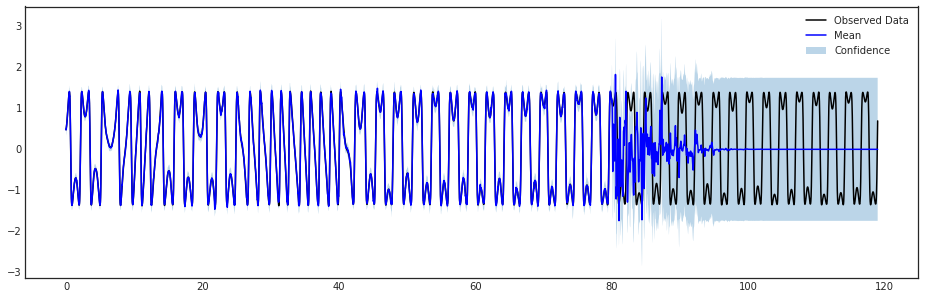

In [40]:
start_traj = 0
end_traj = 11900

fig, ax = plt.subplots(1)

fig.set_figheight(5)
fig.set_figwidth(16)

ax.plot(timeSteps[start_traj:end_traj], Y_theta[start_traj:end_traj].cpu().numpy(), 'k')
ax.plot(timeSteps[start_traj:end_traj], means[start_traj:end_traj], 'b')
ax.fill_between(timeSteps[start_traj:end_traj], lowers[start_traj:end_traj], uppers[start_traj:end_traj], alpha=0.3)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
#plt.savefig('withInducPts(500).png')

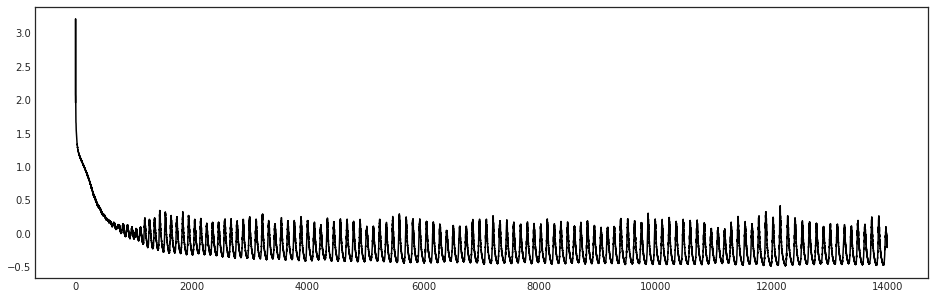

In [41]:
losses = np.array(losses)
plot_loss = np.linspace(0, losses.shape[0], num=losses.shape[0], endpoint=False)

fig, ax = plt.subplots(1)

fig.set_figheight(5)
fig.set_figwidth(16)

ax.plot(plot_loss, losses, 'k')
plt.show()